In [1]:
#mounting google drive to get the data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
#Importing all the necessary packages

import numpy as np
import tensorflow as tf
import keras
import librosa as lb        
import cv2 
import os
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy import save
import matplotlib
%matplotlib inline
import seaborn as sns
matplotlib.rcParams['figure.figsize'] = (20, 20)

from sklearn.metrics import confusion_matrix
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.utils import np_utils
from keras import regularizers
from keras.engine.topology import Layer
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from keras.callbacks import ReduceLROnPlateau
matplotlib.use("Agg")
import itertools


In [3]:
#functon for converting all labels in to one hot vectors
def one_hot_encode(filename):
  label_dict = {"classical":[1,0,0,0,0,0],
                "hiphop":[0,1,0,0,0,0],"jazz":[0,0,1,0,0,0],
                "metal":[0,0,0,1,0,0],"pop":[0,0,0,0,1,0],"reggae":[0,0,0,0,0,1]}
  return label_dict[filename] 

In [4]:
SR = 22050
N_FFT = 512
HOP_LENGTH = N_FFT // 2
N_MELS = 64  

#taking audio input and generating mel-spectograms out of it

def mel_spectogram(file):
  y, sr = lb.load(file)
  melspec = lb.feature.melspectrogram(y = y,sr = sr, hop_length = HOP_LENGTH, n_fft = N_FFT, n_mels = N_MELS)
  melspec_db = lb.power_to_db(melspec,ref = np.max)
  return melspec_db

def list_mel_spectogram(data_file_location,dirname1):
  mel_spect_list = []
  label = []
  for dirname, _, filenames in os.walk(data_file_location):

    if dirname == dirname1:
      
      for filename in filenames:
        
        label.append(np.array(one_hot_encode(filename.split('.')[0])))
        x = np.array(mel_spectogram(os.path.join(dirname, filename)))
        x = cv2.resize(x.reshape(x.shape[0],x.shape[1],1), (2584,64),interpolation = cv2.INTER_CUBIC)
        x = x / np.linalg.norm(x)
        mel_spect_list.append((x.reshape(x.shape[0],x.shape[1],1)))

  return mel_spect_list,label 

def prepare_data():

  data_file_location = '/content/drive/My Drive/projects_google_collab/music genre classification/LSTM/gtzan/_train/_train'
  training_dirname = '/content/drive/My Drive/projects_google_collab/music genre classification/LSTM/gtzan/_train/_train'
  validation_dirname = '/content/drive/My Drive/projects_google_collab/music genre classification/LSTM/gtzan/_validation/_validation'
  test_dirname = '/content/drive/My Drive/projects_google_collab/music genre classification/LSTM/gtzan/_test'

  train_mel_im, train_label = list_mel_spectogram(data_file_location, training_dirname)
  valid_mel_im, valid_label = list_mel_spectogram(validation_dirname, validation_dirname)
  test_mel_im, test_label = list_mel_spectogram(test_dirname, test_dirname)
  

  return train_mel_im, train_label, valid_mel_im, valid_label, test_mel_im, test_label


In [5]:

#making our dataset ready
train_mel_im, train_label, valid_mel_im, valid_label, test_mel_im, test_label = prepare_data()

#saving datasets into drive
save('/content/drive/My Drive/projects_google_collab/music genre classification/train_mel_im.npy',train_mel_im)
save('/content/drive/My Drive/projects_google_collab/music genre classification/train_label.npy',train_label)
save('/content/drive/My Drive/projects_google_collab/music genre classification/valid_mel_im.npy',valid_mel_im)
save('/content/drive/My Drive/projects_google_collab/music genre classification/valid_label.npy',valid_label)
save('/content/drive/My Drive/projects_google_collab/music genre classification/test_mel_im.npy',test_mel_im)
save('/content/drive/My Drive/projects_google_collab/music genre classification/test_label.npy',test_label)



"\ntrain_mel_im, train_label, valid_mel_im, valid_label, test_mel_im, test_label = prepare_data()\nsave('/content/drive/My Drive/projects_google_collab/music genre classification/train_mel_im.npy',train_mel_im)\nsave('/content/drive/My Drive/projects_google_collab/music genre classification/train_label.npy',train_label)\nsave('/content/drive/My Drive/projects_google_collab/music genre classification/valid_mel_im.npy',valid_mel_im)\nsave('/content/drive/My Drive/projects_google_collab/music genre classification/valid_label.npy',valid_label)\nsave('/content/drive/My Drive/projects_google_collab/music genre classification/test_mel_im.npy',test_mel_im)\nsave('/content/drive/My Drive/projects_google_collab/music genre classification/test_label.npy',test_label)\n"

In [6]:
#loading them from drive in case runtime get restart
train_mel_im = np.load('/content/drive/My Drive/projects_google_collab/music genre classification/train_mel_im.npy')
y_train = np.load('/content/drive/My Drive/projects_google_collab/music genre classification/train_label.npy')
valid_mel_im = np.load('/content/drive/My Drive/projects_google_collab/music genre classification/valid_mel_im.npy')
y_val = np.load('/content/drive/My Drive/projects_google_collab/music genre classification/valid_label.npy')
test_mel_im = np.load('/content/drive/My Drive/projects_google_collab/music genre classification/test_mel_im.npy')
y_test = np.load('/content/drive/My Drive/projects_google_collab/music genre classification/test_label.npy')

In [32]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

#making a cnn model
def cnn(num_genres=6, input_shape=(64,2584,1)):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(4, 4),
                     activation='relu', #kernel_regularizer=regularizers.l2(0.04),
                     input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 4)))
    model.add(Conv2D(64, (3, 5), activation='relu'
                    , kernel_regularizer=regularizers.l2(0.04)
                    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (2, 2), activation='relu'
       # , kernel_regularizer=regularizers.l2(0.04)
        ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.04)))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.04)))
    model.add(Dense(num_genres, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
                  metrics=['accuracy'])
    return model
 

In [8]:
model = cnn(num_genres=6, input_shape=(64,2584,1))

learning_rate_reduction = ReduceLROnPlateau(monitor='loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [9]:
history = model.fit(np.array(train_mel_im),np.array(y_train), validation_data=(np.array(valid_mel_im),np.array(y_val)),  
                epochs=250, steps_per_epoch=100, validation_steps=10, batch_size=32,callbacks = [learning_rate_reduction])

Epoch 1/250
100/100 [==============================] - 23s 226ms/step - loss: 3.8801 - accuracy: 0.4937 - val_loss: 3.2732 - val_accuracy: 0.1667
Epoch 2/250
100/100 [==============================] - 22s 219ms/step - loss: 2.2838 - accuracy: 0.7154
Epoch 3/250
100/100 [==============================] - 22s 221ms/step - loss: 1.8477 - accuracy: 0.8256
Epoch 4/250
100/100 [==============================] - 22s 224ms/step - loss: 1.7003 - accuracy: 0.8512
Epoch 5/250
100/100 [==============================] - 23s 227ms/step - loss: 1.5653 - accuracy: 0.8685
Epoch 6/250
100/100 [==============================] - 23s 228ms/step - loss: 1.5477 - accuracy: 0.8822
Epoch 7/250
100/100 [==============================] - 22s 225ms/step - loss: 1.1784 - accuracy: 0.9187
Epoch 8/250
100/100 [==============================] - 23s 227ms/step - loss: 0.9577 - accuracy: 0.9434
Epoch 9/250
100/100 [==============================] - 23s 227ms/step - loss: 1.5993 - accuracy: 0.8712
Epoch 10/250
100/100 [

In [10]:
#checking performance of our model

validation_accuracy = model.evaluate(np.array(valid_mel_im), np.array(y_val))
training_accuracy = model.evaluate(np.array(train_mel_im), np.array(y_train))
testing_accuracy = model.evaluate(np.array(test_mel_im), np.array(y_test))
# print of test error used only after development of the model
print("\nTraining accuracy: %f\t Validation accuracy: %f\t Testing Accuracy: %f" %
      (training_accuracy[1], validation_accuracy[1], testing_accuracy[1]))
print("\nTraining loss: %f    \t Validation loss: %f    \t Testing Loss: %f \n" %
      (training_accuracy[0], validation_accuracy[0], testing_accuracy[0]))
print( )

2/2 [==============================] - 0s 137ms/step - loss: 1.0583 - accuracy: 0.7500

Training accuracy: 1.000000	 Validation accuracy: 0.683333	 Testing Accuracy: 0.750000

Training loss: 0.195068    	 Validation loss: 1.180556    	 Testing Loss: 1.058340 




Confusion matrix, without normalization
[[20  0  0  0  0  0]
 [ 0 12  1  5  1  1]
 [ 1  1 16  2  0  0]
 [ 0  1  0 19  0  0]
 [ 2  2  0  0 11  5]
 [ 0 15  0  1  0  4]]


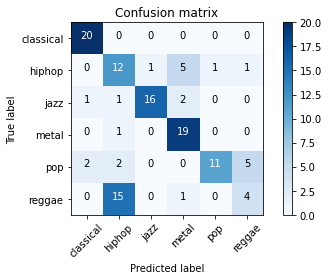

In [34]:
%matplotlib inline
labels = ['classical','hiphop','jazz','metal','pop','reggae']

# plotting confusion matrix
Y_pred = model.predict(np.array(valid_mel_im))
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(np.array(y_val),axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = labels,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)



problem is with reggae only model considering reggae as hip hop

In [15]:
#Saving model and model weights

# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")


Saved model to disk


**Taking Audio input and performing classification on that**

In [35]:
!pip install ffmpeg-python

In [36]:
"""
To write this piece of code I took inspiration/code from a lot of places.
It was late night, so I'm not sure how much I created or just copied o.O
Here are some of the possible references:
https://blog.addpipe.com/recording-audio-in-the-browser-using-pure-html5-and-minimal-javascript/
https://stackoverflow.com/a/18650249
https://hacks.mozilla.org/2014/06/easy-audio-capture-with-the-mediarecorder-api/
https://air.ghost.io/recording-to-an-audio-file-using-html5-and-js/
https://stackoverflow.com/a/49019356
"""
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)
  
  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

In [37]:
audio, sr = get_audio() 
#music is taken from this --> https://www.youtube.com/watch?v=312Sb-2PovA

In [38]:
def mel_spectogram(audio,sr):
  #y, sr = lb.load(file)
  melspec = lb.feature.melspectrogram(y = audio.astype(float),sr = sr, hop_length = HOP_LENGTH, n_fft = N_FFT, n_mels = N_MELS)
  melspec_db = lb.power_to_db(melspec,ref = np.max)
  return melspec_db

In [40]:

x = np.array(mel_spectogram((audio),float(sr)))
x = x / np.linalg.norm(x)
x = cv2.resize(x.reshape(x.shape[0],x.shape[1],1), (2584,64),interpolation = cv2.INTER_CUBIC)
pred = model.predict((x.reshape(1,x.shape[0],x.shape[1],1)))

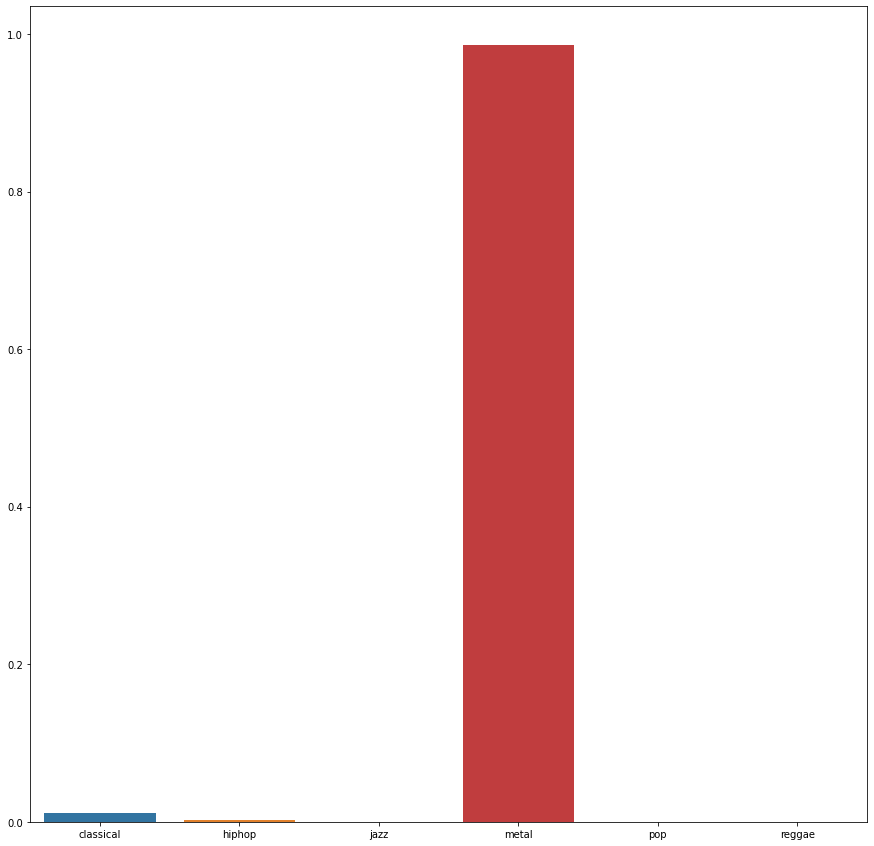

<Figure size 432x288 with 0 Axes>

In [41]:
%matplotlib inline 
plt.figure(figsize = (15,15))
sns.barplot(x = ['classical','hiphop','jazz','metal','pop','reggae'],y = pred[0])
plt.show()
plt.savefig('random_music_test.png')